# *📊 Employee Attrition - Data Cleansing*

---

## Author  
**Kfir Tayar** 

## *Notebook Overview*  
- Check for missing values  
- Plot a Boxplot to detect outliers  
- Replace outliers with NaN  
- Plot Heatmap of the outliers  
- Check if imputation is needed 
- Save the cleansing file as a Pickle file

In [1]:
# Import Libraries & Modules
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy.stats import norm, ks_2samp

# Add the path to the utils directory
sys.path.append(os.path.abspath('../utils'))

from data_cleansing_utils import plot_missing_heatmap, replace_outliers_with_nan
from data_prep_utils import save_file_as_pickle

### Load Data Set

In [3]:
processed_df = pd.read_pickle("../Data/processed_employee_data_20250325.pkl")

In [4]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74498 entries, 0 to 74497
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Gender                    74498 non-null  category
 1   Years at Company          74498 non-null  int64   
 2   Job Role                  74498 non-null  category
 3   Monthly Income            74498 non-null  int64   
 4   Work-Life Balance         74498 non-null  category
 5   Job Satisfaction          74498 non-null  category
 6   Performance Rating        74498 non-null  category
 7   Number of Promotions      74498 non-null  category
 8   Overtime                  74498 non-null  category
 9   Distance from Home        74498 non-null  int64   
 10  Education Level           74498 non-null  category
 11  Marital Status            74498 non-null  category
 12  Number of Dependents      74498 non-null  category
 13  Job Level                 74498 non-null  cate

In [5]:
processed_df_cp = processed_df.copy()

In [6]:
# Insure that there is 0 missing values
sum(processed_df.isna().sum())

0

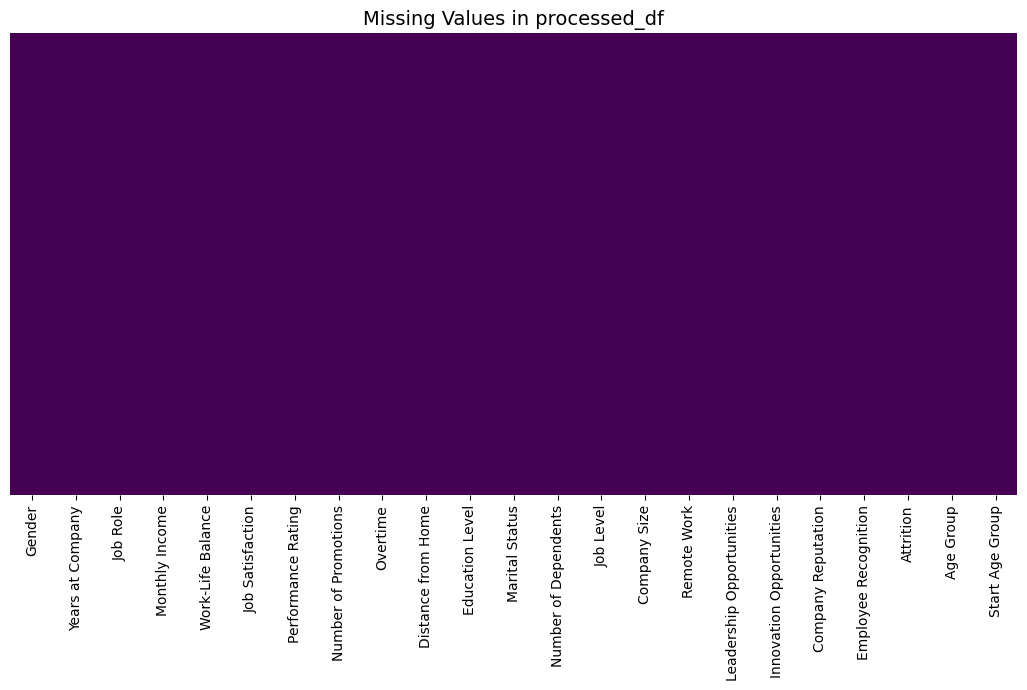

In [7]:
# Visualize missing values in processed_df
plot_missing_heatmap(processed_df, "Missing Values in processed_df")

<Axes: >

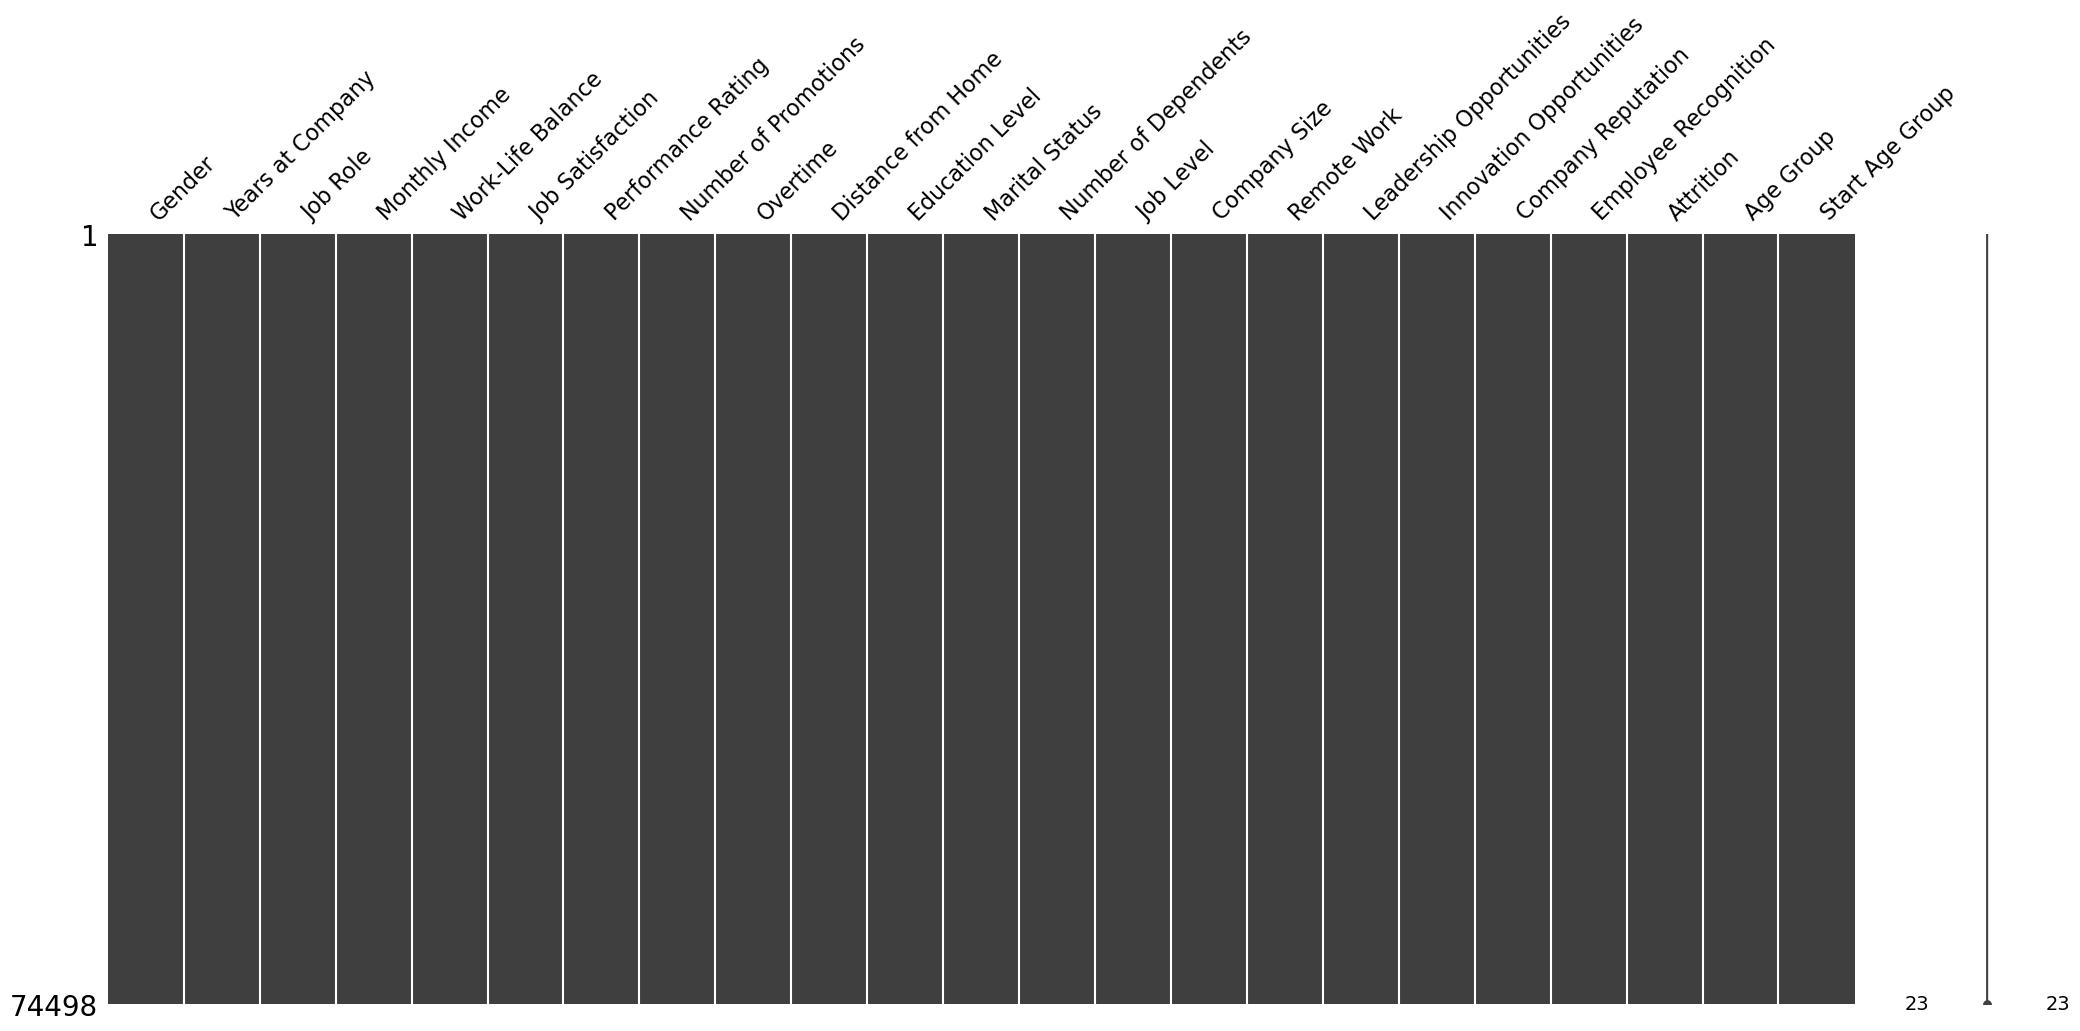

In [8]:
msno.matrix(processed_df)

### Create Boxplots for the continuous features

In [10]:
con_df = processed_df.select_dtypes(include=['number'])
con_df.head()

,Years at Company,Monthly Income,Distance from Home
0,19,5390,22
1,4,5534,21
2,10,8159,11
3,7,3989,27
4,41,4821,71


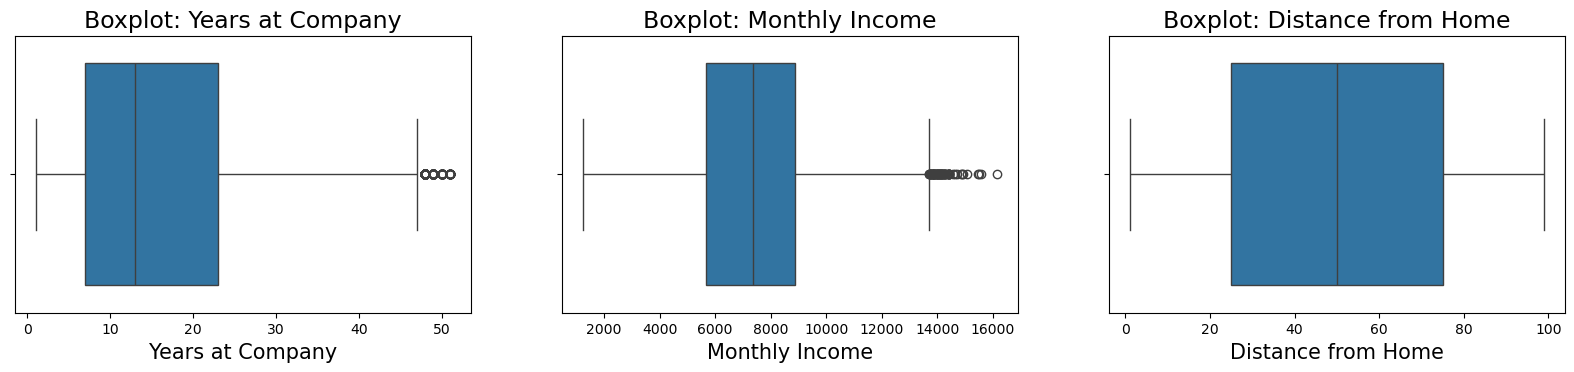

In [11]:
plt.figure(figsize=(20,200))

for i, col in enumerate(con_df.columns): 
    ax = plt.subplot(40, 3, i+1)
    sns.boxplot(data=con_df, x=col, ax=ax)
    plt.subplots_adjust(hspace = 0.4)
    plt.title('Boxplot: {}'.format(col), fontsize=17)
    plt.xlabel('{}'.format(col), fontsize=15)


- There is outlies in **'Years at Company'** & **'Monthly Income'** featues

### Turn the outlies into Missing Values

In [23]:
# Take only the features that include outliers
con_df = con_df.drop(columns=['Distance from Home'])

In [25]:
# Replace the outliers with NaN values using IQR method
con_df_clean = replace_outliers_with_nan(con_df, threshold=1.5)
con_df_clean.head()

,Years at Company,Monthly Income
0,19.0,5390.0
1,4.0,5534.0
2,10.0,8159.0
3,7.0,3989.0
4,41.0,4821.0


In [27]:
# Sum of outliers
con_df_clean.isna().sum()

Years at Company    338
Monthly Income       65
dtype: int64

In [29]:
con_df_clean[con_df_clean.isna().any(axis=1)]

,Years at Company,Monthly Income
387,14.0,NaN
465,NaN,8460.0
662,NaN,5236.0
843,NaN,8295.0
1373,NaN,5527.0
...,...,...
74041,NaN,10852.0
74045,NaN,8448.0
74052,27.0,NaN
74304,NaN,5876.0


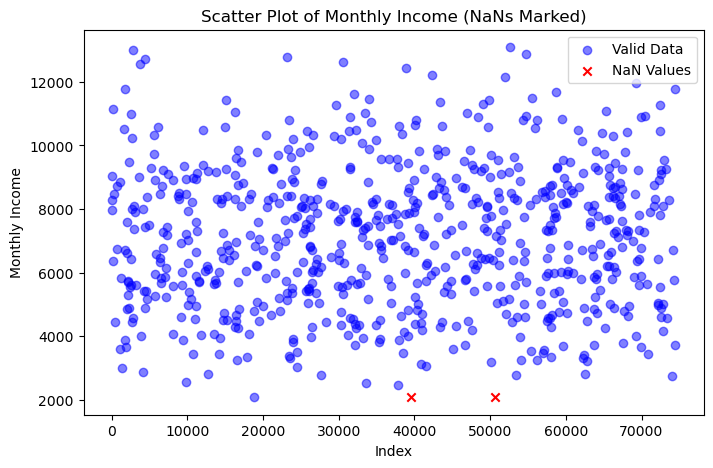

In [31]:
# Take a sample of 700 random rows from con_df_clean
sampled_indices = con_df_clean.sample(n=700, random_state=6).index
sampled_con_df_clean = con_df_clean.loc[sampled_indices]

plt.figure(figsize=(8, 5))

# Identify NaN values
nan_mask = sampled_con_df_clean['Monthly Income'].isna()

# Plot non-NaN values in blue
plt.scatter(sampled_con_df_clean.index[~nan_mask], sampled_con_df_clean['Monthly Income'][~nan_mask], alpha=0.5, label="Valid Data", color='blue')

# Plot NaN values in red
plt.scatter(sampled_con_df_clean.index[nan_mask], np.full(nan_mask.sum(), sampled_con_df_clean['Monthly Income'].min() - 1), 
            color='red', label="NaN Values", marker='x')

plt.xlabel("Index")
plt.ylabel("Monthly Income")
plt.title("Scatter Plot of Monthly Income (NaNs Marked)")
plt.legend()
plt.show()


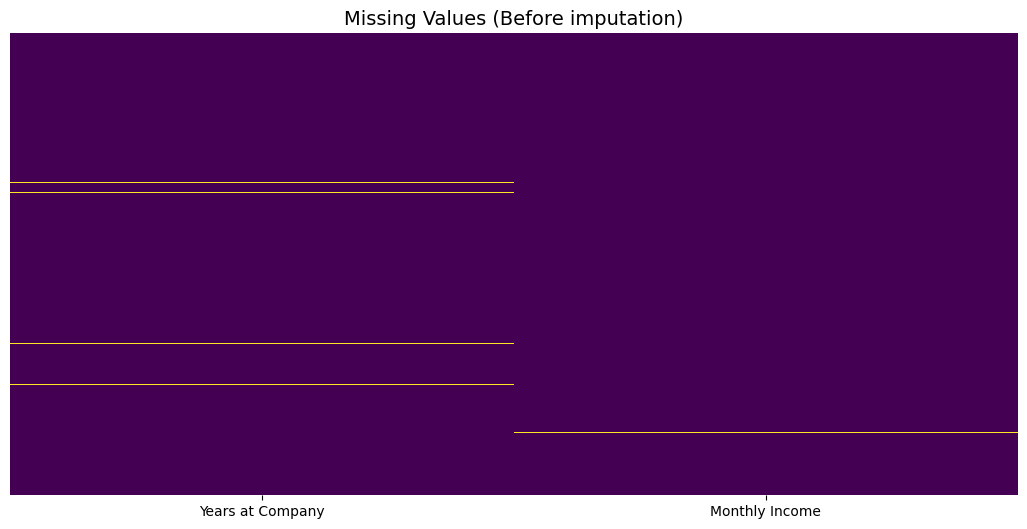

In [35]:
# Visualize missing values before imputation
plot_missing_heatmap(con_df_clean, "Missing Values (Before imputation)")

<Axes: >

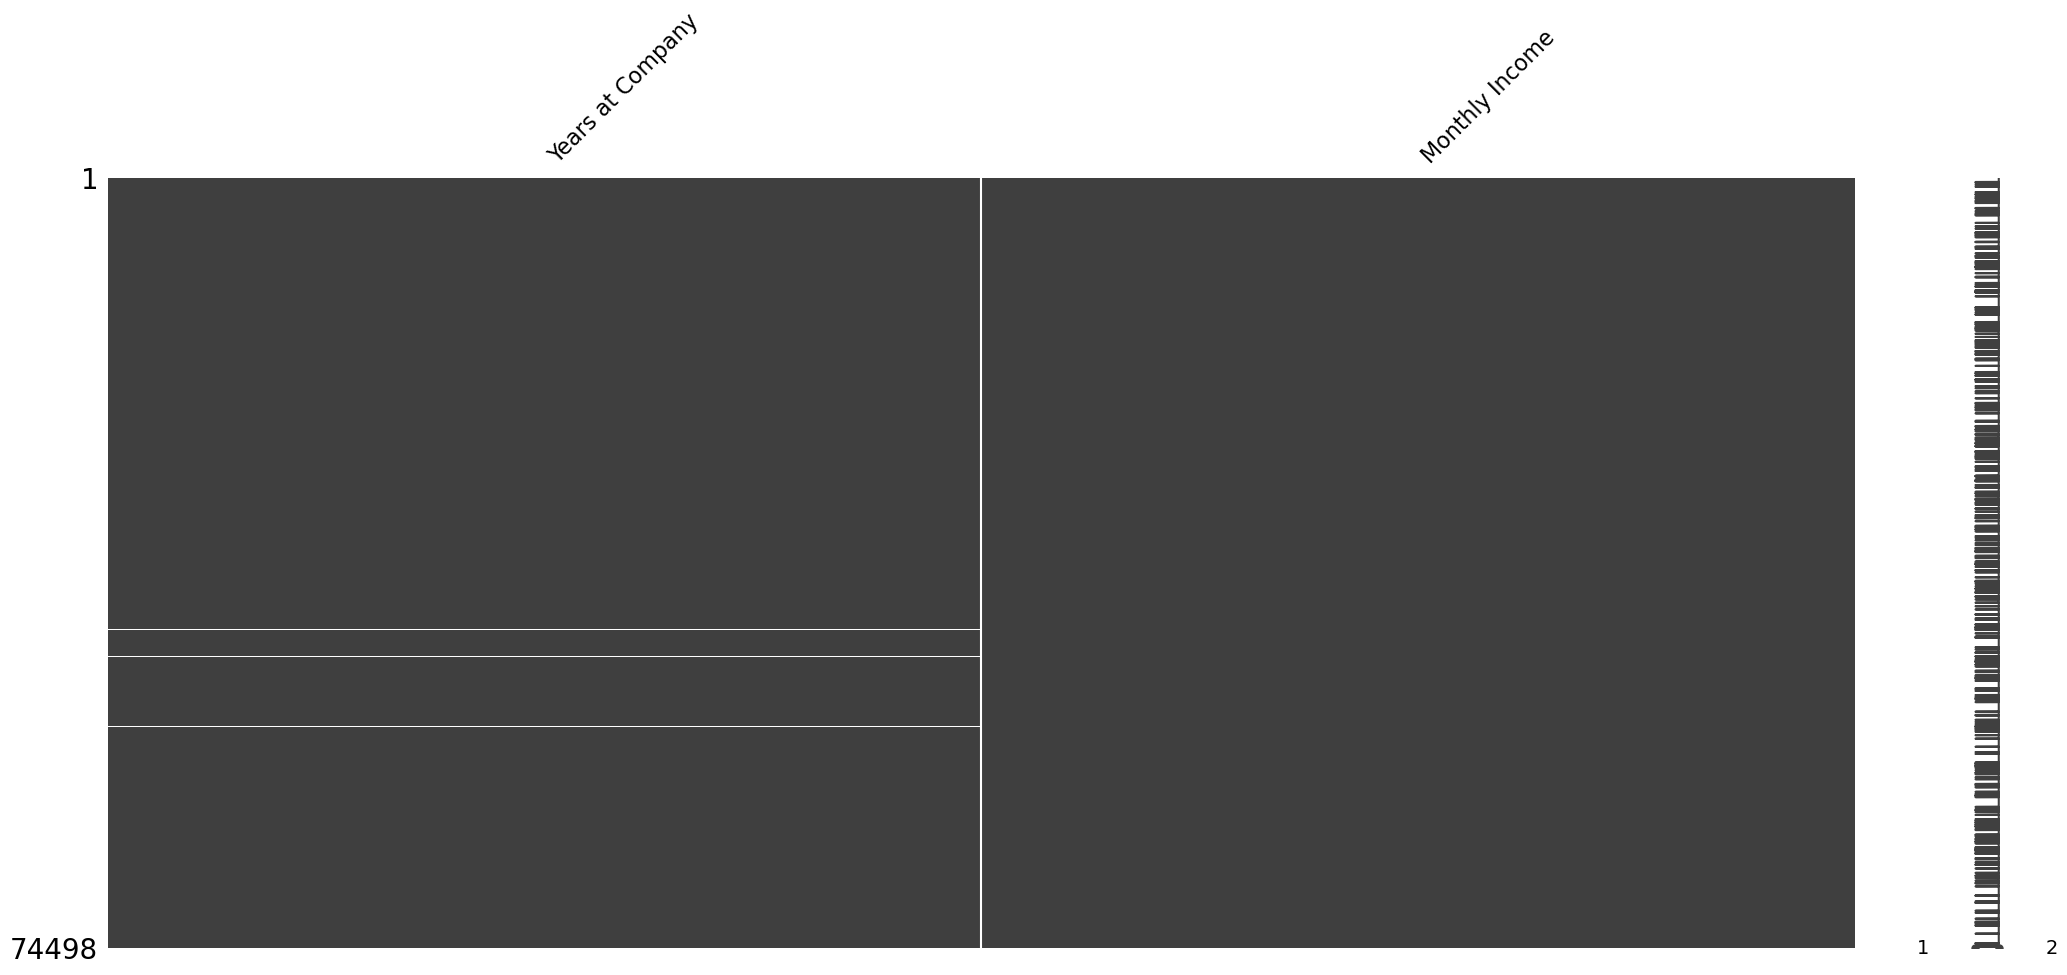

In [37]:
msno.matrix(con_df_clean)

### Chack if imputation is needed

In [40]:
# Convert 'Attrition' to numeric: 'Stayed' → 1, 'Left' → 0
processed_df_cp["Attrition"] = processed_df_cp["Attrition"].map({"Stayed": 1, "Left": 0})

In [42]:
processed_df_cp['Attrition'] = processed_df_cp['Attrition'].astype('int64')

In [44]:
#Creating a table for outliers change
out_df = pd.DataFrame(columns=['feature', 'outliers_cnt', 'distribution_changed', 'correlation_changed'])

In [46]:
# Checking distribution and correlation changes
for col in con_df_clean:
    # Extract values
    out = processed_df_cp[col] # Data with outliers
    non_out = processed_df_cp.loc[~con_df_clean[col].isna(), col]  # Data without outliers
    
    cor_out = processed_df_cp['Attrition']
    cor_non_out = processed_df_cp.loc[~con_df_clean[col].isna(), 'Attrition']

    # Filter out NaN values for correlation calculation
    valid_out = ~np.isnan(out) & ~np.isnan(cor_out)
    valid_non_out = ~np.isnan(non_out) & ~np.isnan(cor_non_out)

    if valid_out.sum() > 1 and valid_non_out.sum() > 1:
        cor_change = '+' if abs(np.corrcoef(out[valid_out], cor_out[valid_out])[0, 1] -
                                np.corrcoef(non_out[valid_non_out], cor_non_out[valid_non_out])[0, 1]) > 0.05 else '-'
    else:
        cor_change = '-'
        
    # KS test for distribution difference
    dist_change = '+' if ks_2samp(out.dropna(), non_out.dropna())[1] < 0.05 else '-'

    # Store results
    new_row = pd.DataFrame({'feature': [col],
                            'outliers_cnt': [con_df_clean[col].isna().sum()],
                            'distribution_changed': [dist_change],
                            'correlation_changed': [cor_change]})

    out_df = pd.concat([out_df, new_row], ignore_index=True)

In [48]:
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed
0,Years at Company,338,-,-
1,Monthly Income,65,-,-


In [50]:
# Add the 'drop' column based on the specified conditions
out_df['drop'] = np.where((out_df['distribution_changed'] == '+') & (out_df['correlation_changed'] == '-'), 'yes', 'no')

# Filter features where only distribution changes but not correlation
to_drop = out_df[out_df['drop'] == 'yes']['feature']

# Display the resulting DataFrame
out_df

,feature,outliers_cnt,distribution_changed,correlation_changed,drop
0,Years at Company,338,-,-,no
1,Monthly Income,65,-,-,no


In [52]:
relevant_columns=out_df.loc[out_df['drop']=='yes']
relevant_columns

,feature,outliers_cnt,distribution_changed,correlation_changed,drop


In [54]:
# Update con_df_clean to include only the features that need to be dropped
con_df_clean = con_df_clean[relevant_columns.feature]

print('The imputation process is needed') if len(con_df_clean.columns) else print('The imputation process is not needed!') 

The imputation process is not needed!


In [56]:
cleansing_df = processed_df.copy()

### Save df as a Pickle file

In [59]:
folder = "data"
file_name = "cleansing_employee_data"

save_file_as_pickle(cleansing_df, folder, file_name)

File saved as: ../data/cleansing_employee_data_20250325.pkl
